In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing the required packages
import pandas as pd
import numpy as np
import re
import timeit
import warnings
import string
import seaborn as sn
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist

# Importing Sci-kit learn functions for evaluation and dataset analysis purpose
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tkinter import ttk
from tkinter import *
import time
import plotly.figure_factory as ff

# Loading the ML Models used to classify the data into hate, offensive and neither category
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Function used to pre-process the dataset
import re


def preprocessing(text):
    #print(text)
    text = re.sub(r'@\S+', '', text)  # Remove @mentions
    text = re.sub(r'http\S+', '', text)  # Remove URLs starting with http
    text = re.sub(r'www\S+', '', text)  # Remove URLs starting with www
    text = re.sub(r'#\S+', '', text)  # Remove hashtags
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r' +', ' ', text).strip()  # Remove extra spaces and strip text
    #text = remove_emoji(text)  # Remove emojis using the custom function
    return text


In [ ]:
# Loading the Data set for Training
df_train_orig = pd.read_csv("/content/drive/MyDrive/Disseration UoN/Datasets/arabic_train.csv") # ,names=["tweets","class"])

In [ ]:
# Printing first 'n' data from the loaded training data dataframe
n = 10
df_train_orig.head(n)

,Tweet,Class
0,وزير الخارجية اللبناني جبران باسيل قال في سلسل...,normal
1,سورية بلد الحضارات تربطها بعلية او بحيوان,normal
2,اخي الحاج اذا شعرت انك محرجا من الانتقادات لتص...,normal
3,ما فيك تعيش بلا ما تكب فتن ليل نهار وبكرة قلهم...,normal
4,هذا البطل الذي قاتل وجاذف بحياته لتحيا انت يا ...,abusive
5,ولعها وهيك بتكون الشقيقة قدمت اكبر خدمة لشقيقت...,normal
6,قبل ما تترحم وسام الحسن كان مشارك بقتل الحريري...,normal
7,كلنا معك معالي الوزير الملك جبران باسيل,normal
8,ولك مبارح أيها المريض النفسي كنت عم تدافع عن ا...,normal
9,انو غريب يوجعك راسك القواتجية عادة بيكونو بلا راس,hate


In [ ]:
# Checking whether any data with null entries are present or not
df_train_orig[df_train_orig["Tweet"].isna()]

,Tweet,Class


In [ ]:
# Null entries filled with unknown tags
df_train = df_train_orig.fillna("unknown")

In [ ]:
# Printing total amount of data with null entries
print(df_train.isna().sum(),"\n")

Tweet    0
Class    0
dtype: int64 



In [ ]:
# No. of classes present for this Arabic dataset
n_classes = len(np.unique(df_train["Class"]))
print("Number of classes:",n_classes)

Number of classes: 3


<ipython-input-11-ef20adfafbf6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Class', palette='Set2')


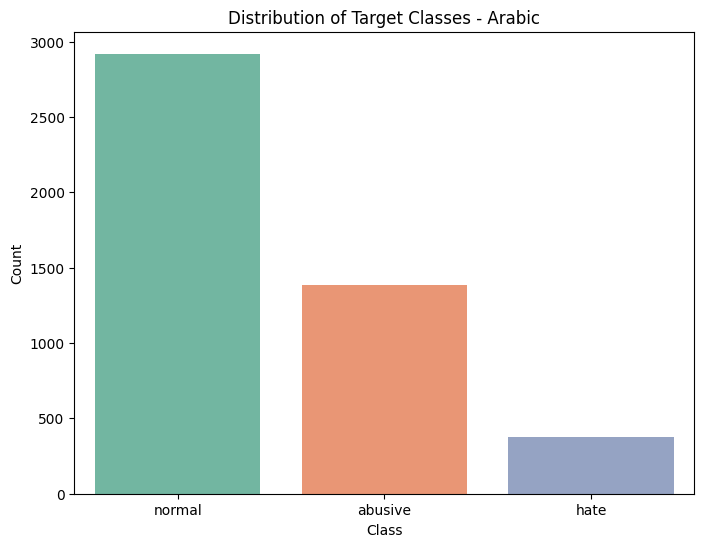

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ploting the target distribution
def plot_class_distribution(df, language):
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='Class', palette='Set2')
    plt.title(f"Distribution of Target Classes - {language}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

plot_class_distribution(df_train, "Arabic")


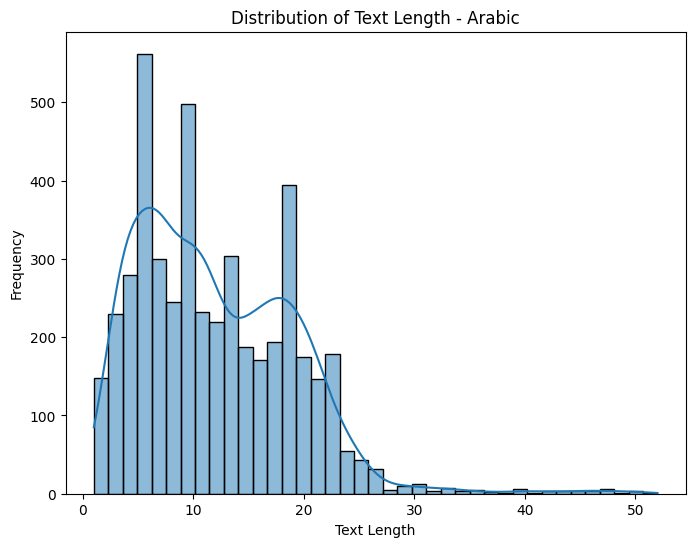

In [ ]:
import nltk

#Plotting the distribution of text length
def plot_text_length_distribution(df, language):
    text_lengths = df['Tweet'].apply(lambda x: len(nltk.word_tokenize(x)))
    plt.figure(figsize=(8, 6))
    sns.histplot(text_lengths, kde=True)
    plt.title(f"Distribution of Text Length - {language}")
    plt.xlabel("Text Length")
    plt.ylabel("Frequency")
    plt.show()

plot_text_length_distribution(df_train, "Arabic")


<ipython-input-13-9d61e5d7aac1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Class', y='text_length', palette='Set3')


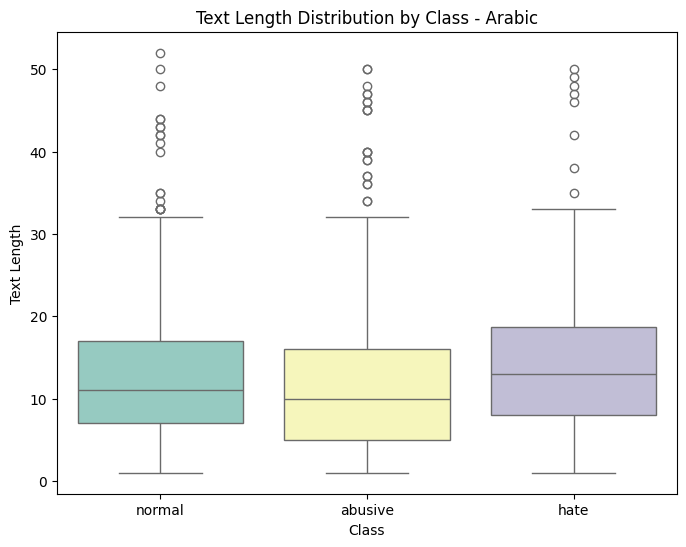

In [ ]:
# Plotting the text length distribution by class

def plot_text_length_by_class(df, language):
    df['text_length'] = df['Tweet'].apply(lambda x: len(nltk.word_tokenize(x)))
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x='Class', y='text_length', palette='Set3')
    plt.title(f"Text Length Distribution by Class - {language}")
    plt.xlabel("Class")
    plt.ylabel("Text Length")
    plt.show()

plot_text_length_by_class(df_train, "Arabic")


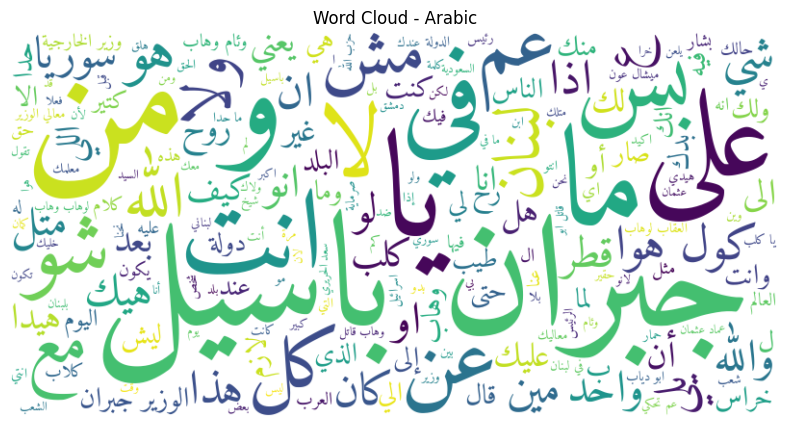

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

arabic_font_path = '/content/drive/MyDrive/Disseration UoN/Datasets/Amiri-Regular.ttf'

# plotting the word cloud
def generate_word_cloud(df, language):
    # Join the tokens into a single string
    text = ' '.join(df['Tweet'].astype(str))  # Ensure the 'Tweet' column is in string format
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=arabic_font_path).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {language}")
    plt.show()

generate_word_cloud(df_train, "Arabic")


<ipython-input-15-8684dd189916>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngrams_df, palette='coolwarm')


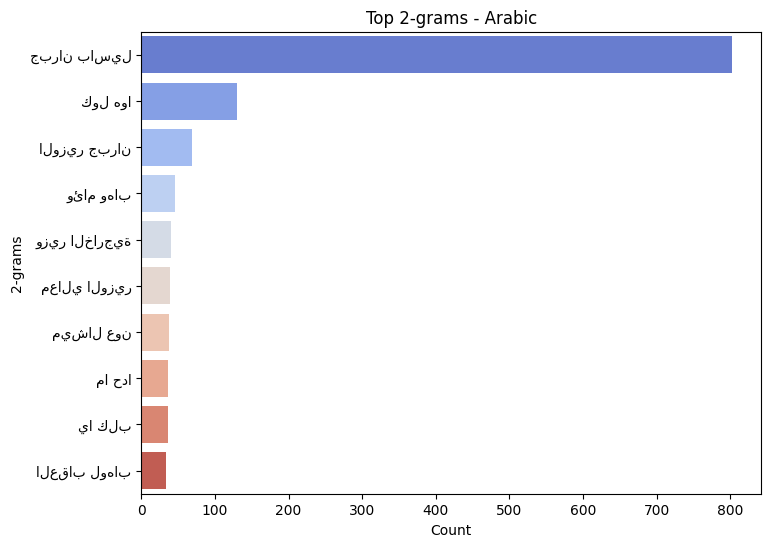

<ipython-input-15-8684dd189916>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngrams_df, palette='coolwarm')


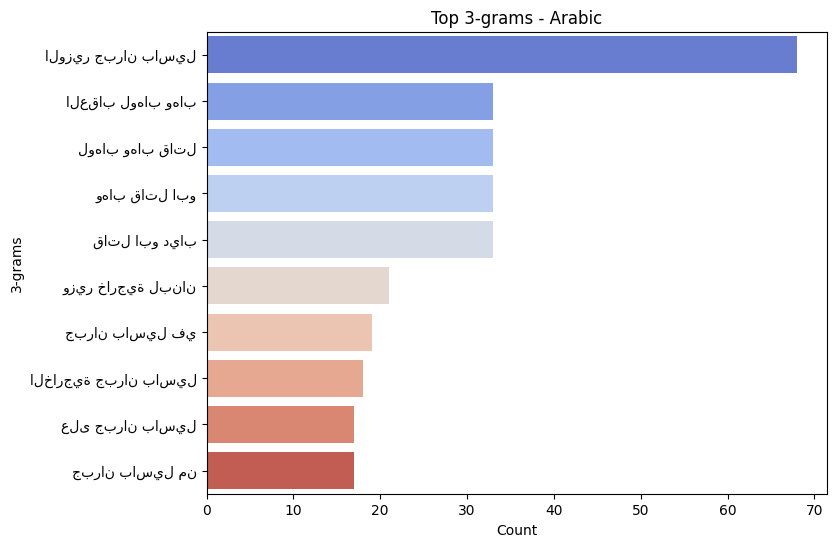

In [ ]:
from nltk.util import ngrams
from collections import Counter

def get_ngrams(text, n=2):
    tokens = nltk.word_tokenize(text)
    n_grams = list(ngrams(tokens, n))
    return n_grams

# plotting the n-grams
def plot_ngrams(df, language, n=2):
    all_text = ' '.join(df['Tweet'])
    ngrams_list = get_ngrams(all_text, n)
    ngrams_freq = Counter(ngrams_list).most_common(10)

    ngrams_df = pd.DataFrame(ngrams_freq, columns=['ngram', 'count'])
    ngrams_df['ngram'] = ngrams_df['ngram'].apply(lambda x: ' '.join(x))

    plt.figure(figsize=(8, 6))
    sns.barplot(x='count', y='ngram', data=ngrams_df, palette='coolwarm')
    plt.title(f"Top {n}-grams - {language}")
    plt.xlabel("Count")
    plt.ylabel(f"{n}-grams")
    plt.show()

plot_ngrams(df_train, "Arabic", n=2)  # For Bigrams
plot_ngrams(df_train, "Arabic", n=3)  # For Trigrams
